In [29]:
import sys
import numpy as np
from matplotlib import pyplot
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.10.0+cu111


**Generate training data:**

Synthesizing our own data for this practice problem by computing the sin(x)+cos(3*x) for a range of x values, and adding some noise

x min:  [-8.99961158]
x max: [8.99959589]
y min:  [-0.88741345]
y max: [0.89772492]


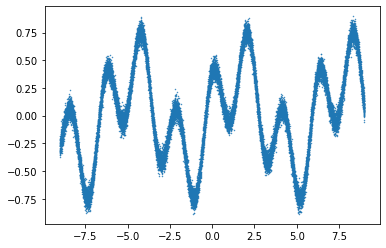

In [30]:
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints

x_train = np.random.rand(n_x_train,1)*18 - 9  # Initialize a vector of with dimensions [n_x, 1] and extend
y_train = (np.sin(x_train)+np.cos(3*x_train))/2.5           # Calculate the sin of all data points in the x vector and reduce amplitude
y_train += (np.random.randn(n_x_train, 1)/20)  # add noise to each datapoint

x_test = np.random.rand(n_x_test, 1)*18 - 9   # Repeat data generation for test set
y_test = (np.sin(x_test)+np.cos(3*x_test))/2.5
y_test += (np.random.randn(n_x_test, 1)/20)

print("x min: ", min(x_train))
print("x max:", max(x_train))
print("y min: ", min(y_train))
print("y max:", max(y_train))

fig0 = pyplot.figure()  # initialize a plot
pyplot.scatter(x_train, y_train, marker='o', s=0.2)  # plot x vs y
pyplot.show()  # open a window with the plot (you have to close it for the script to finish)

**A pytorch Dataset object to contain the training and testing data**

In [31]:
class SineCosDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE or L1 Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

**Training methods for the model**

In [32]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=10):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

**Testing methods for the model**

In [33]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector

**Plotting method for loss**

In [34]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

**Model architecture**

In [35]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, H2, H3, D_out = [1, 64, 64, 64, 1]    # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.tanh(x)       # activation function
        
        x = self.linear2(x) # hidden layer
        x = torch.tanh(x)       # activation function
        
        x = self.linear3(x) # hidden layer
        x = torch.tanh(x)       # activation function

        x = self.linear4(x) # output layer
        
        return x

**Method to define hyperparameters, train, and test**

In [36]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-3
    shallow_model = ShallowLinear()
    
    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn)
    
    # Test and get the resulting predicted y values
    y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict

**Initiate training, plot testing results**

Train set size:  30000
Test set size:  8000
Epoch:  1
Batches:  1875
Epoch:  2
Batches:  3750
Epoch:  3
Batches:  5625
Epoch:  4
Batches:  7500
Epoch:  5
Batches:  9375
Epoch:  6
Batches:  11250
Epoch:  7
Batches:  13125
Epoch:  8
Batches:  15000
Epoch:  9
Batches:  16875
Epoch:  10
Batches:  18750
Final loss: 0.006441333368420601


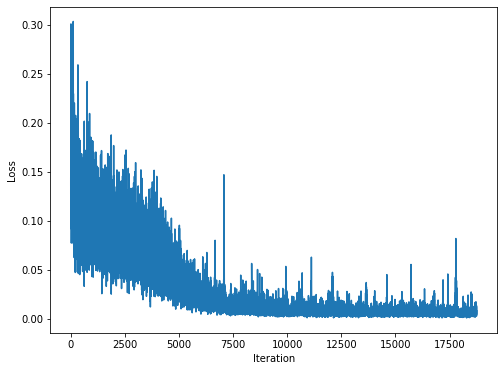

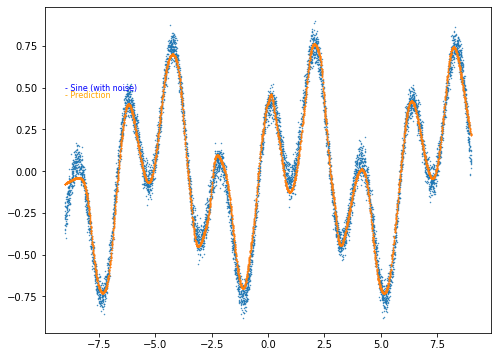

In [37]:
dataset_train = SineCosDataset(x=x_train, y=y_train)
dataset_test = SineCosDataset(x=x_test, y=y_test)

print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)

losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)

print("Final loss:", sum(losses[-100:])/100)
plot_loss(losses)

fig2 = pyplot.figure()
fig2.set_size_inches(8,6)
pyplot.scatter(x_test, y_test, marker='o', s=0.2)
pyplot.scatter(x_test, y_predict, marker='o', s=0.3)
pyplot.text(-9, 0.44, "- Prediction", color="orange", fontsize=8)
pyplot.text(-9, 0.48, "- Sine (with noise)", color="blue", fontsize=8)
pyplot.show()